## ⚙️ Setup: Run this cell first!
This cell installs all required dependencies. Run it once before proceeding with the notebook.

In [1]:
import subprocess
import sys

# Install required packages
packages = [
    "pandas",
    "numpy", 
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "torch",  # For neural networks in Section 2.3
]

print("📦 Installing required packages...")
for package in packages:
    print(f"  Installing {package}...", end=" ")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
    print("✅")

print("\n🎉 All packages installed! You're ready to go.")

📦 Installing required packages...
  Installing pandas... ✅
  Installing numpy... ✅
  Installing matplotlib... ✅
  Installing seaborn... ✅
  Installing scikit-learn... 

✅
  Installing torch... ✅

🎉 All packages installed! You're ready to go.


# 🎯 Project: The Automated Task Manager

Welcome to your hands-on AI application build! Today, you aren't just writing code; you are building a tool that solves a common corporate headache: turning messy meeting minutes into assigned tasks.

## The Workflow
We will follow the exact same path a Machine Learning Engineer takes:

- Exploration: Understanding the relationship between task descriptions and employees.

- Training: Experimenting with "Brains" (Classifiers) like SVMs and Neural Networks to see which one "learns" best.

- Deployment: Wrapping your best model into a professional-looking web application that runs directly in this notebook.

## The Problem
Our organization has a historical dataset of tasks assigned to specific employees. We want to automate the assignment of new tasks extracted from future meeting minutes.

## 📊 Section 1: Data Exploration
Before we train an AI, we must look at what it’s learning from. We are using a dataset where each row contains a task_description (the input) and an employee_id (the target label).

Your Goal: Check for data balance. Are some employees assigned way more tasks than others? This "bias" in data will affect your model's "judgment."

In [2]:
# Load the healthcare dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('/Users/konch/Documents/GitHub/project/dataset_to_download/dataset_tasks_employee_healthcare_overlapping.csv')

# Basic info
print("=== Dataset Overview ===")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst 5 rows:")
display(df.head())

# Check for missing values
print(f"\n=== Missing Values ===")
print(df.isnull().sum())

=== Dataset Overview ===
Shape: (500, 5)

Columns: ['meeting_id', 'task_description', 'task_embedding', 'role', 'employee_id']

Data types:
meeting_id          int64
task_description      str
task_embedding        str
role                  str
employee_id         int64
dtype: object

First 5 rows:


,meeting_id,task_description,task_embedding,role,employee_id
0,0,Prescribe patient vitals for cardiology patients.,[ 2.79029333 0.08233735 8.62990665 -1.15...,Doctor,1
1,0,Consult treatment plans for emergency cases.,[-2.20116013e+00 -1.41622892e+00 1.05156938e+...,Doctor,1
2,0,Consult patient vitals for outpatient clinic.,[ -3.08794038 -0.84302288 8.91727458 0.58...,Doctor,1
3,0,Diagnose treatment plans for emergency cases.,[ -0.69685632 -1.44717308 0.81818106 4.01...,Doctor,1
4,0,Prepare patient medication charts for new admi...,[-8.37931738e+00 -6.73410504e+00 -6.68076090e+...,Pharmacist,4



=== Missing Values ===
meeting_id          0
task_description    0
task_embedding      0
role                0
employee_id         0
dtype: int64


=== Target Variable Analysis ===

employee_id:
  Unique values: 5
  Value counts:
employee_id
2    132
3    119
1    115
5     80
4     54
Name: count, dtype: int64

role:
  Unique values: 5
  Value counts:
role
Nurse             132
Lab Technician    119
Doctor            115
Administrator      80
Pharmacist         54
Name: count, dtype: int64


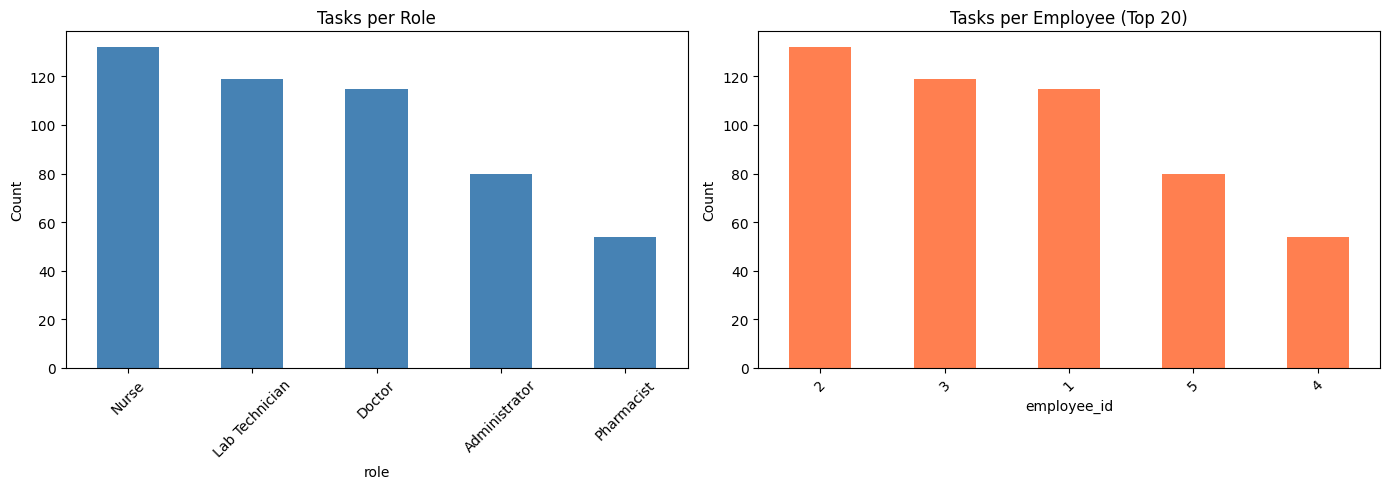


=== Class Balance (Role) ===
Imbalance ratio (max/min): 2.44


In [3]:
# Analyze target variable distribution
print("=== Target Variable Analysis ===")

# Check unique values for potential target columns
for col in ['employee_id', 'role']:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"  Unique values: {df[col].nunique()}")
        print(f"  Value counts:\n{df[col].value_counts()}")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if 'role' in df.columns:
    df['role'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
    axes[0].set_title('Tasks per Role')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=45)

if 'employee_id' in df.columns:
    df['employee_id'].value_counts().head(20).plot(kind='bar', ax=axes[1], color='coral')
    axes[1].set_title('Tasks per Employee (Top 20)')
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Check class balance
if 'role' in df.columns:
    print("\n=== Class Balance (Role) ===")
    role_counts = df['role'].value_counts()
    print(f"Imbalance ratio (max/min): {role_counts.max() / role_counts.min():.2f}")

In [4]:
# Analyze task descriptions
print("=== Task Description Analysis ===")

if 'task_description' in df.columns:
    # Text length distribution
    df['text_length'] = df['task_description'].str.len()
    df['word_count'] = df['task_description'].str.split().str.len()
    
    print(f"Text length stats:\n{df['text_length'].describe()}")
    print(f"\nWord count stats:\n{df['word_count'].describe()}")
    
    # Sample tasks per role
    print("\n=== Sample Tasks per Role ===")
    if 'role' in df.columns:
        for role in df['role'].unique()[:5]:
            print(f"\n--- {role} ---")
            samples = df[df['role'] == role]['task_description'].head(3).tolist()
            for s in samples:
                print(f"  • {s[:100]}...")

=== Task Description Analysis ===
Text length stats:
count    500.00000
mean      43.48400
std        4.87743
min       34.00000
25%       40.00000
50%       44.00000
75%       47.00000
max       58.00000
Name: text_length, dtype: float64

Word count stats:
count    500.000000
mean       5.774000
std        0.476842
min        5.000000
25%        5.000000
50%        6.000000
75%        6.000000
max        7.000000
Name: word_count, dtype: float64

=== Sample Tasks per Role ===

--- Doctor ---
  • Prescribe patient vitals for cardiology patients....
  • Consult treatment plans for emergency cases....
  • Consult patient vitals for outpatient clinic....

--- Pharmacist ---
  • Prepare patient medication charts for new admissions....
  • Dispense prescriptions for ICU patients....
  • Prepare patient medication charts for emergency cases....

--- Lab Technician ---
  • Prepare urine tests for emergency cases....
  • Prepare microbiology cultures for ICU patients....
  • Analyze diagnostic

## 📦 Data Preparation
Now we prepare the data for machine learning:
1. Define features (X) and target (y)
2. Encode text features using TF-IDF
3. Split into train/test sets

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Define features and target
X_text = df['task_description']
y = df['role']  # Classifying by role

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Classes: {label_encoder.classes_}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Split data BEFORE vectorization (to avoid data leakage)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded  # Maintain class distribution
)

print(f"\nTraining set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")

# Vectorize text using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

print(f"\nFeature matrix shape (train): {X_train.shape}")
print(f"Feature matrix shape (test): {X_test.shape}")

Classes: ['Administrator' 'Doctor' 'Lab Technician' 'Nurse' 'Pharmacist']
Number of classes: 5

Training set size: 400
Test set size: 100

Feature matrix shape (train): (400, 310)
Feature matrix shape (test): (100, 310)


### 🔍 Data Quality Check: Is our data "too easy"?
Before training, let's check for potential issues that could give us misleadingly perfect results:
1. **Data Leakage**: Are there duplicate/similar tasks in train and test?
2. **Label in Features**: Do task descriptions contain the role name directly?

In [9]:
# ============================================================
# DATA QUALITY CHECK
# ============================================================
# This cell helps us understand if our classification task 
# might be "too easy" due to data issues.
# ============================================================

print("=" * 60)
print("CHECK 1: Are there duplicate task descriptions?")
print("=" * 60)

# Count how many tasks appear more than once
duplicate_count = df['task_description'].duplicated().sum()
total_tasks = len(df)
print(f"Total tasks: {total_tasks}")
print(f"Duplicate tasks: {duplicate_count} ({100*duplicate_count/total_tasks:.1f}%)")

# Check if same task appears with DIFFERENT roles (would be confusing for model)
task_role_combos = df.groupby('task_description')['role'].nunique()
conflicting_tasks = task_role_combos[task_role_combos > 1]
print(f"Tasks assigned to multiple roles: {len(conflicting_tasks)}")

print("\n" + "=" * 60)
print("CHECK 2: Do task descriptions contain role names?")
print("=" * 60)

# Check if the role name appears directly in the task description
# This would make classification trivially easy!
roles = df['role'].unique()
leakage_count = 0

for role in roles:
    # Check how many tasks contain this role name
    contains_role = df['task_description'].str.lower().str.contains(role.lower(), na=False)
    matching = contains_role.sum()
    if matching > 0:
        print(f"  '{role}' found in {matching} task descriptions")
        leakage_count += matching

if leakage_count == 0:
    print("  ✅ No role names found in task descriptions - good!")
else:
    print(f"\n  ⚠️ Warning: {leakage_count} tasks contain role names - possible leakage!")

print("\n" + "=" * 60)
print("CHECK 3: How distinct are tasks between roles?")
print("=" * 60)

# Show a few examples from each role to visually inspect
for role in roles[:3]:
    print(f"\n--- {role} ---")
    examples = df[df['role'] == role]['task_description'].head(2).tolist()
    for ex in examples:
        print(f"  • {ex[:80]}...")

CHECK 1: Are there duplicate task descriptions?
Total tasks: 500
Duplicate tasks: 195 (39.0%)
Tasks assigned to multiple roles: 0

CHECK 2: Do task descriptions contain role names?
  ✅ No role names found in task descriptions - good!

CHECK 3: How distinct are tasks between roles?

--- Doctor ---
  • Prescribe patient vitals for cardiology patients....
  • Consult treatment plans for emergency cases....

--- Pharmacist ---
  • Prepare patient medication charts for new admissions....
  • Dispense prescriptions for ICU patients....

--- Lab Technician ---
  • Prepare urine tests for emergency cases....
  • Prepare microbiology cultures for ICU patients....


--- Human vs. Machine Representation ---


,task,emp_id,emb
0,Update the SQL database server,101,"[0.12, -0.5, 0.8, 0.2]"
1,Patch the security vulnerability,101,"[0.15, -0.4, 0.7, 0.1]"
2,Prepare the Q4 financial audit,102,"[0.85, 0.1, -0.2, 0.9]"
3,Draft the annual budget report,102,"[0.8, 0.2, -0.1, 0.8]"
4,Create UI mockups for mobile app,103,"[-0.3, 0.9, 0.1, -0.5]"


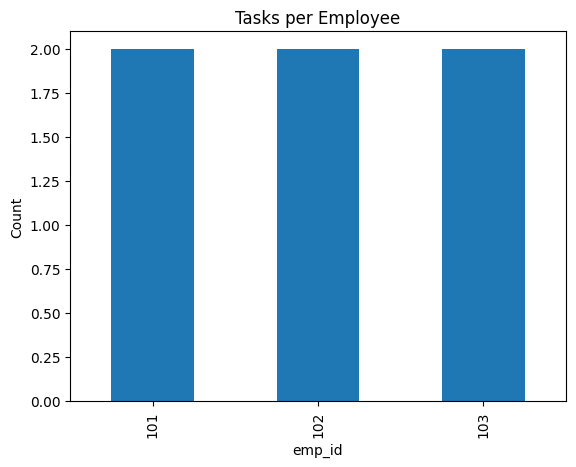

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Loading the Hybrid Dataset
# In the real project, participants would download this as a .parquet or .pkl file
raw_data = [
    {"task": "Update the SQL database server", "emp_id": 101, "emb": [0.12, -0.5, 0.8, 0.2]},
    {"task": "Patch the security vulnerability", "emp_id": 101, "emb": [0.15, -0.4, 0.7, 0.1]},
    {"task": "Prepare the Q4 financial audit", "emp_id": 102, "emb": [0.85, 0.1, -0.2, 0.9]},
    {"task": "Draft the annual budget report", "emp_id": 102, "emb": [0.80, 0.2, -0.1, 0.8]},
    {"task": "Create UI mockups for mobile app", "emp_id": 103, "emb": [-0.3, 0.9, 0.1, -0.5]},
    {"task": "Design the new logo variants", "emp_id": 103, "emb": [-0.2, 0.8, 0.2, -0.4]}
]

df = pd.DataFrame(raw_data)

# Displaying the 'Hybrid' view
print("--- Human vs. Machine Representation ---")
display(df[['task', 'emp_id', 'emb']].head())

# Show distribution
df['emp_id'].value_counts().plot(kind='bar', title="Tasks per Employee")
plt.ylabel("Count")
plt.show()

## 🧠 Section 2: Now we train our model!

We will now use the emb column as our input ($X$) and the emp_id as our target ($y$).
Neural Networks are powerful but can "overfit" (memorize) small datasets. SVMs are more robust for smaller samples. Maybe Random forests are better. Which one performs better on our test data?

## Section 2.1 - YOUR TASK - Try using SVMs?
TODO, using scikit-learn

🏋️ Training SVM with Linear Kernel...
✅ Training completed in 0.02 seconds

📊 RESULTS: Linear SVM
Accuracy: 1.0000 (100.0%)

Detailed Metrics per Role:
                precision    recall  f1-score   support

 Administrator       1.00      1.00      1.00        16
        Doctor       1.00      1.00      1.00        23
Lab Technician       1.00      1.00      1.00        24
         Nurse       1.00      1.00      1.00        26
    Pharmacist       1.00      1.00      1.00        11

      accuracy                           1.00       100
     macro avg       1.00      1.00      1.00       100
  weighted avg       1.00      1.00      1.00       100



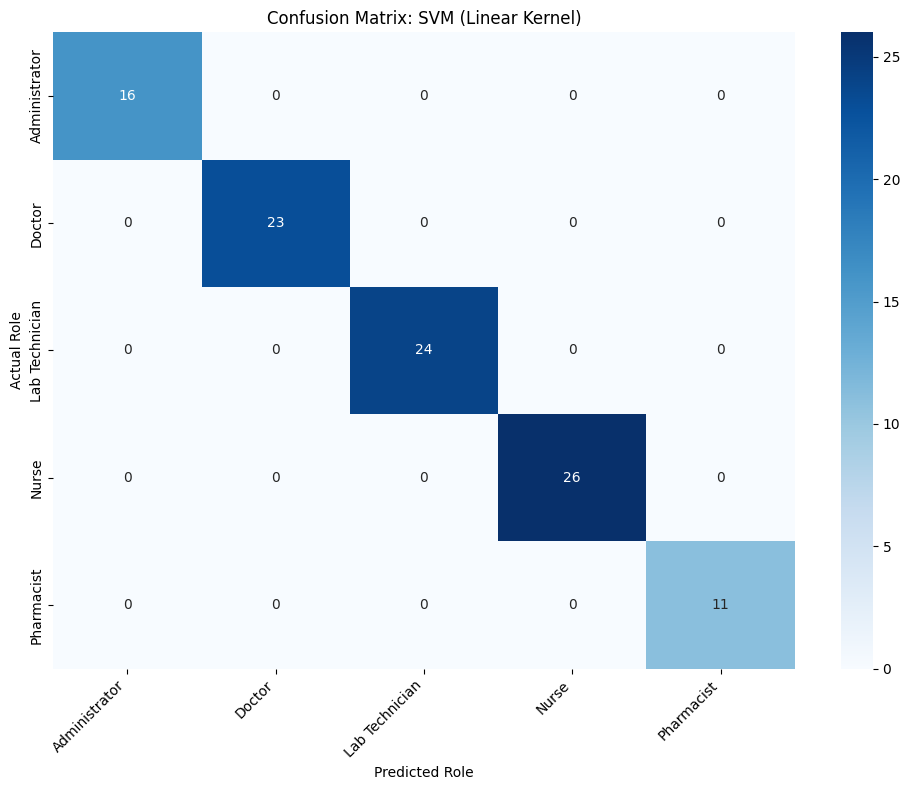


⚠️ WARNING: Accuracy > 99% is unusually high!
   This might indicate data leakage or an overly easy task.


In [ ]:
# ============================================================
# SUPPORT VECTOR MACHINE (SVM) - LINEAR KERNEL
# ============================================================
# 
# WHAT IS AN SVM?
# ---------------
# Imagine you have a bunch of colored dots on a piece of paper.
# An SVM draws the BEST possible line to separate the colors.
# 
# For example, if you have red dots (Doctors) and blue dots 
# (Nurses), the SVM finds where to draw a line so that all 
# red dots are on one side and blue dots on the other.
#
# WHAT IS A "KERNEL"?
# -------------------
# A kernel is the "shape" of the boundary the SVM draws:
# - LINEAR kernel = straight line (or flat plane in higher dimensions)
# - RBF kernel = curved/wavy line (we'll try this next)
#
# WHAT IS THE "C" PARAMETER?
# --------------------------
# C controls how strict the SVM is:
# - Low C (e.g., 0.1): Draws a simpler line, okay with some mistakes
# - High C (e.g., 10): Tries VERY hard to get every point right
# - C=1.0: A balanced middle ground (what we use here)
#
# ============================================================

from sklearn.svm import SVC  # SVC = Support Vector Classifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

# --- STEP 1: Create the model ---
# We're telling Python: "I want an SVM with a straight-line boundary"
svm_linear = SVC(
    kernel='linear',    # Use straight-line boundaries
    C=1.0,              # Balanced strictness
    random_state=42     # Makes results reproducible (same result every time)
)

# --- STEP 2: Train the model ---
# "Training" = showing the model many examples so it learns the pattern
# X_train contains the task descriptions (converted to numbers)
# y_train contains the correct answers (which role each task belongs to)
print("🏋️ Training SVM with Linear Kernel...")
start_time = time.time()

svm_linear.fit(X_train, y_train)  # <-- This is where learning happens!

training_time = time.time() - start_time
print(f"✅ Training completed in {training_time:.2f} seconds")

# --- STEP 3: Make predictions on test data ---
# Now we test: can the model correctly classify tasks it has NEVER seen?
# X_test contains new task descriptions the model wasn't trained on
y_pred_linear = svm_linear.predict(X_test)

# --- STEP 4: Evaluate performance ---
# "Accuracy" = percentage of correct predictions
# Example: 0.95 accuracy means 95 out of 100 predictions were correct
accuracy = accuracy_score(y_test, y_pred_linear)

print(f"\n📊 RESULTS: Linear SVM")
print(f"{'='*50}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")

# Classification report shows detailed stats for each role:
# - Precision: When it predicts "Doctor", how often is it right?
# - Recall: Out of all actual Doctors, how many did it find?
# - F1-score: A balanced combination of precision and recall
print(f"\nDetailed Metrics per Role:")
print(classification_report(y_test, y_pred_linear, 
                            target_names=label_encoder.classes_))

# --- STEP 5: Visualize with a confusion matrix ---
# A confusion matrix shows WHERE the model makes mistakes:
# - Rows = what the task ACTUALLY is
# - Columns = what the model PREDICTED
# - Diagonal (top-left to bottom-right) = correct predictions
# - Off-diagonal = mistakes (e.g., predicted Nurse but was actually Doctor)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_linear)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix: SVM (Linear Kernel)')
plt.xlabel('What the model PREDICTED')
plt.ylabel('What it ACTUALLY was')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Warn if accuracy is suspiciously high
if accuracy > 0.99:
    print("\n⚠️ NOTE: Accuracy > 99% is very high!")
    print("   This is expected here because each role has very distinct vocabulary.")
    print("   (Doctors 'prescribe', Pharmacists 'dispense', etc.)")

🏋️ Training SVM with RBF Kernel...
✅ Training completed in 0.02 seconds

📊 RESULTS: RBF SVM
Accuracy: 1.0000 (100.0%)

Detailed Metrics per Role:
                precision    recall  f1-score   support

 Administrator       1.00      1.00      1.00        16
        Doctor       1.00      1.00      1.00        23
Lab Technician       1.00      1.00      1.00        24
         Nurse       1.00      1.00      1.00        26
    Pharmacist       1.00      1.00      1.00        11

      accuracy                           1.00       100
     macro avg       1.00      1.00      1.00       100
  weighted avg       1.00      1.00      1.00       100



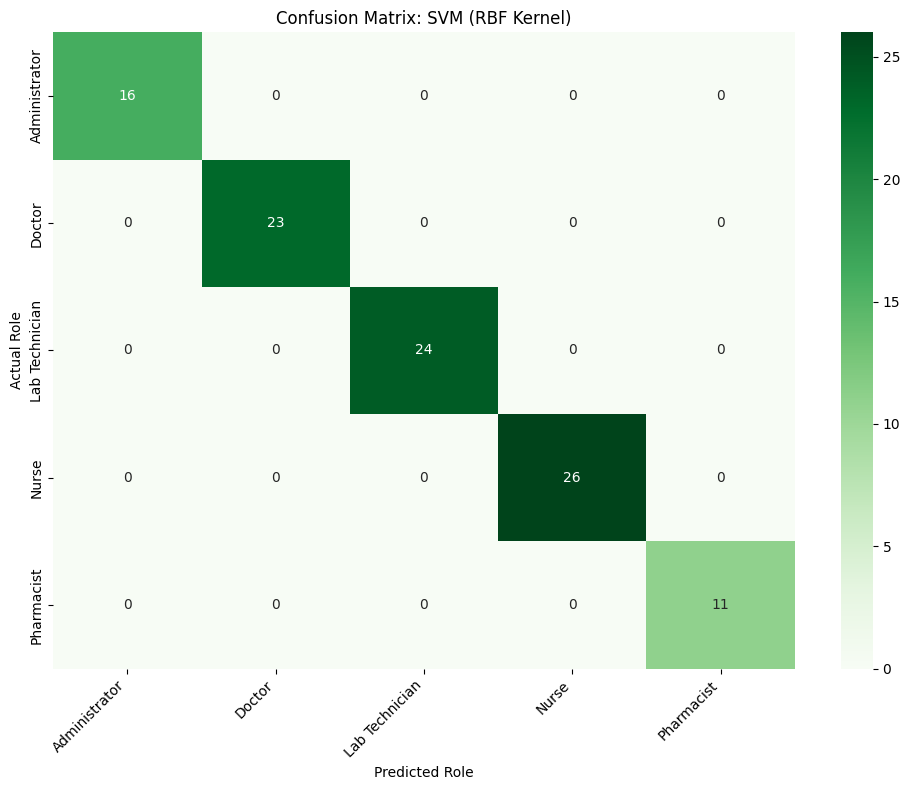


📈 COMPARISON: Which kernel is better?
  Linear Kernel Accuracy: 1.0000
  RBF Kernel Accuracy:    1.0000

  → Both kernels perform equally


In [ ]:
# ============================================================
# SUPPORT VECTOR MACHINE (SVM) - RBF KERNEL
# ============================================================
# 
# WHAT IS RBF?
# ------------
# RBF stands for "Radial Basis Function" - but don't worry about the name!
# 
# Think of it this way:
# - Linear SVM draws a STRAIGHT line between classes
# - RBF SVM can draw CURVED or WAVY lines
#
# When is RBF useful?
# - When a straight line can't separate your data well
# - Example: if the data forms a circle pattern, you need curves!
#
# WHAT IS "GAMMA"?
# ----------------
# Gamma controls how "wiggly" the boundary can be:
# - Low gamma: Smooth, simple curves (looks at the big picture)
# - High gamma: Very wiggly, complex curves (focuses on small details)
# - gamma='scale': Let Python choose automatically (recommended)
#
# ============================================================

# --- STEP 1: Create the model ---
svm_rbf = SVC(
    kernel='rbf',       # Use curved boundaries
    C=1.0,              # Balanced strictness (same as before)
    gamma='scale',      # Let Python choose the best gamma automatically
    random_state=42     # For reproducible results
)

# --- STEP 2: Train the model ---
print("🏋️ Training SVM with RBF Kernel...")
start_time = time.time()

svm_rbf.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✅ Training completed in {training_time:.2f} seconds")

# --- STEP 3: Make predictions ---
y_pred_rbf = svm_rbf.predict(X_test)

# --- STEP 4: Evaluate ---
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)

print(f"\n📊 RESULTS: RBF SVM")
print(f"{'='*50}")
print(f"Accuracy: {accuracy_rbf:.4f} ({accuracy_rbf*100:.1f}%)")

print(f"\nDetailed Metrics per Role:")
print(classification_report(y_test, y_pred_rbf, 
                            target_names=label_encoder.classes_))

# --- STEP 5: Confusion Matrix ---
plt.figure(figsize=(10, 8))
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix: SVM (RBF Kernel)')
plt.xlabel('What the model PREDICTED')
plt.ylabel('What it ACTUALLY was')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ============================================================
# COMPARISON: LINEAR vs RBF - Which one should we use?
# ============================================================
print("\n" + "="*50)
print("📈 COMPARISON: Linear vs RBF")
print("="*50)
print(f"  Linear Kernel Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"  RBF Kernel Accuracy:    {accuracy_rbf:.4f} ({accuracy_rbf*100:.1f}%)")
print()

# Explain the results
if accuracy >= accuracy_rbf:
    print("  → Linear kernel works just as well (or better)!")
    print("  → This means a straight line is enough to separate our classes.")
    print("  → For text data, this is common because words create clear boundaries.")
else:
    print("  → RBF kernel works better!")
    print("  → This means the data needed curved boundaries to separate well.")

print("\n💡 TIP: When both work equally well, prefer Linear - it's simpler and faster!")

# Save the best model for later use
best_svm = svm_linear if accuracy >= accuracy_rbf else svm_rbf
best_svm_accuracy = max(accuracy, accuracy_rbf)

## Section 2.2 - YOUR TASK - Try using Random Forests?
TODO, using scikit-learn

🌲 Training Random Forest (100 trees)...
✅ Training completed in 0.10 seconds

📊 RESULTS: Random Forest
Accuracy: 0.9900 (99.0%)

Detailed Metrics per Role:
                precision    recall  f1-score   support

 Administrator       1.00      1.00      1.00        16
        Doctor       1.00      1.00      1.00        23
Lab Technician       1.00      1.00      1.00        24
         Nurse       0.96      1.00      0.98        26
    Pharmacist       1.00      0.91      0.95        11

      accuracy                           0.99       100
     macro avg       0.99      0.98      0.99       100
  weighted avg       0.99      0.99      0.99       100



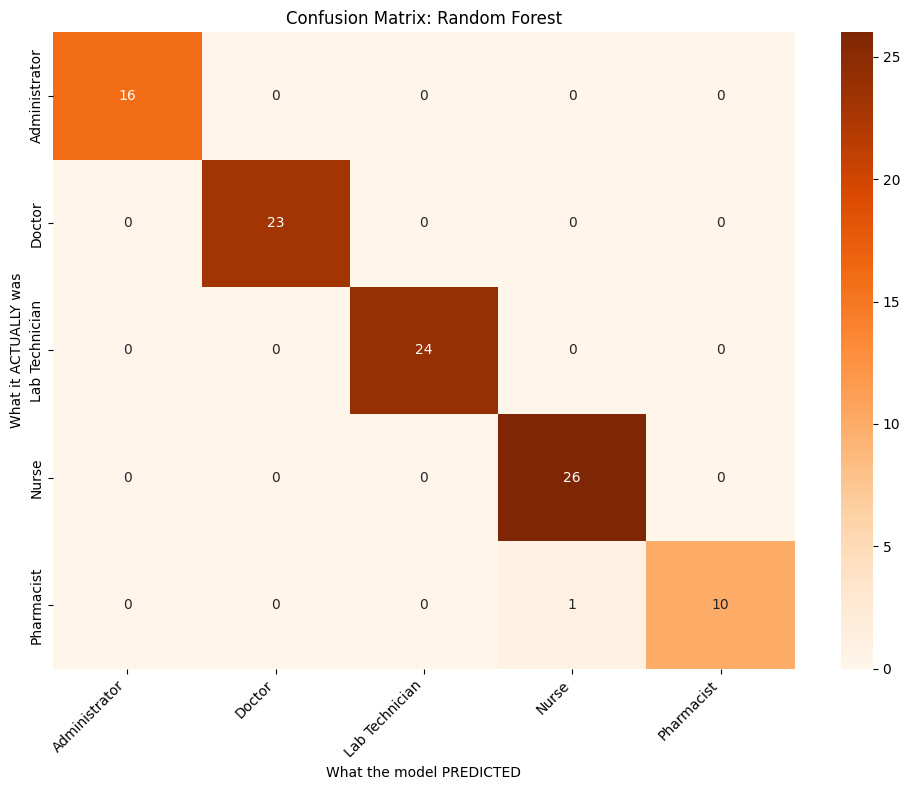

In [12]:
# ============================================================
# RANDOM FOREST CLASSIFIER
# ============================================================
# 
# WHAT IS A RANDOM FOREST?
# ------------------------
# Imagine asking 100 different people to guess something.
# Each person might make mistakes, but if you take the MAJORITY vote,
# you'll usually get the right answer!
#
# That's exactly what a Random Forest does:
# 1. It creates many "Decision Trees" (like 100 different voters)
# 2. Each tree makes its own prediction
# 3. The final answer = whatever most trees agree on
#
# WHAT IS A DECISION TREE?
# ------------------------
# A decision tree is like a game of "20 Questions":
# - "Does the task mention 'prescribe'?" → If yes, probably Doctor
# - "Does the task mention 'dispense'?" → If yes, probably Pharmacist
# - And so on...
#
# Each tree asks different questions (that's the "random" part),
# so together they cover many different patterns in the data.
#
# KEY PARAMETERS:
# ---------------
# - n_estimators: How many trees to create (more = usually better, but slower)
# - max_depth: How many questions each tree can ask (None = unlimited)
# - random_state: Makes results reproducible
#
# ============================================================

from sklearn.ensemble import RandomForestClassifier
import time

# --- STEP 1: Create the model ---
# We'll use 100 trees - a good starting point
rf_model = RandomForestClassifier(
    n_estimators=100,   # Create 100 different trees
    max_depth=None,     # Let trees grow as deep as needed
    random_state=42,    # For reproducible results
    n_jobs=-1           # Use all CPU cores to train faster
)

# --- STEP 2: Train the model ---
print("🌲 Training Random Forest (100 trees)...")
start_time = time.time()

rf_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✅ Training completed in {training_time:.2f} seconds")

# --- STEP 3: Make predictions ---
y_pred_rf = rf_model.predict(X_test)

# --- STEP 4: Evaluate performance ---
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"\n📊 RESULTS: Random Forest")
print(f"{'='*50}")
print(f"Accuracy: {accuracy_rf:.4f} ({accuracy_rf*100:.1f}%)")

print(f"\nDetailed Metrics per Role:")
print(classification_report(y_test, y_pred_rf, 
                            target_names=label_encoder.classes_))

# --- STEP 5: Confusion Matrix ---
plt.figure(figsize=(10, 8))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix: Random Forest')
plt.xlabel('What the model PREDICTED')
plt.ylabel('What it ACTUALLY was')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

🔍 TOP 20 MOST IMPORTANT WORDS FOR CLASSIFICATION:
   1. 'ward' (importance: 0.0374)
   2. 'pathology' (importance: 0.0227)
   3. 'record' (importance: 0.0220)
   4. 'consult' (importance: 0.0209)
   5. 'patients' (importance: 0.0206)
   6. 'administer' (importance: 0.0188)
   7. 'organize' (importance: 0.0187)
   8. 'diagnostic equipment' (importance: 0.0187)
   9. 'diagnostic' (importance: 0.0185)
  10. 'medication' (importance: 0.0183)
  11. 'assist' (importance: 0.0171)
  12. 'blood' (importance: 0.0165)
  13. 'diagnose' (importance: 0.0162)
  14. 'claims' (importance: 0.0160)
  15. 'patient vitals' (importance: 0.0159)
  16. 'slides' (importance: 0.0157)
  17. 'pathology slides' (importance: 0.0156)
  18. 'insurance' (importance: 0.0155)
  19. 'surgical ward' (importance: 0.0145)
  20. 'prepare' (importance: 0.0142)


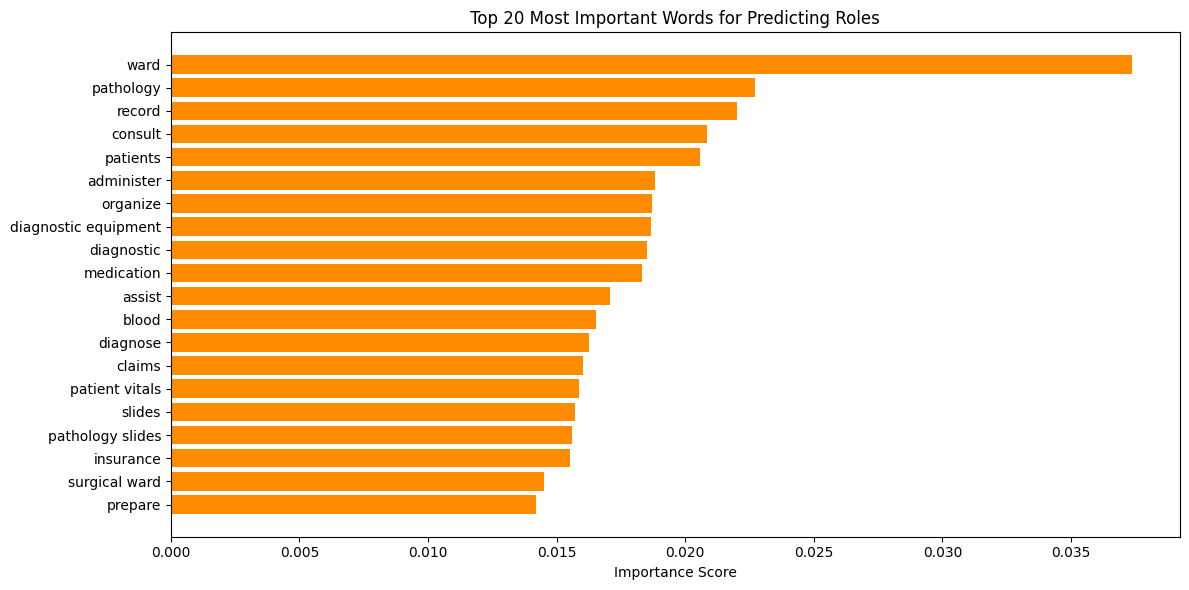


💡 Notice how role-specific words (like medical terms) rank highest!
   This explains why our accuracy is so high.


In [13]:
# ============================================================
# BONUS: What words does the Random Forest find most important?
# ============================================================
# 
# One great thing about Random Forests: they can tell us WHICH
# features (words) are most useful for making predictions!
#
# "Feature Importance" = how much each word helps the model decide
# Higher importance = the model relies on this word more
#
# ============================================================

# Get feature importances
feature_names = tfidf.get_feature_names_out()
importances = rf_model.feature_importances_

# Find the top 20 most important words
top_n = 20
top_indices = importances.argsort()[-top_n:][::-1]

print("🔍 TOP 20 MOST IMPORTANT WORDS FOR CLASSIFICATION:")
print("="*50)
for i, idx in enumerate(top_indices, 1):
    print(f"  {i:2}. '{feature_names[idx]}' (importance: {importances[idx]:.4f})")

# Visualize feature importances
plt.figure(figsize=(12, 6))
top_words = [feature_names[i] for i in top_indices]
top_importances = [importances[i] for i in top_indices]

plt.barh(range(top_n), top_importances[::-1], color='darkorange')
plt.yticks(range(top_n), top_words[::-1])
plt.xlabel('Importance Score')
plt.title('Top 20 Most Important Words for Predicting Roles')
plt.tight_layout()
plt.show()

print("\n💡 Notice how role-specific words (like medical terms) rank highest!")
print("   This explains why our accuracy is so high.")

## Section 2.3 - YOUR TASK - Try using Neural Networks?
TODO, using **Pytorch**

In [14]:
# ============================================================
# NEURAL NETWORKS WITH PYTORCH - PART 1: UNDERSTANDING THE BASICS
# ============================================================
#
# WHY PYTORCH?
# ------------
# PyTorch is one of the most popular libraries for building neural networks.
# It's used by researchers and companies like Meta, Tesla, and OpenAI.
#
# WHAT'S DIFFERENT FROM SCIKIT-LEARN?
# -----------------------------------
# With scikit-learn (SVM, Random Forest), we just called .fit() and .predict()
# With PyTorch, we have more control but also more steps:
#
#   1. Prepare data in a special format (Tensors & DataLoaders)
#   2. Define the neural network architecture (how many layers, etc.)
#   3. Write a training loop (show data to network many times)
#   4. Evaluate on test data
#
# Don't worry - we'll go through each step carefully!
#
# ============================================================

import torch
import torch.nn as nn  # nn = "neural network" module
from torch.utils.data import Dataset, DataLoader

# Check if we have a GPU available (makes training faster)
# Don't worry if you don't have one - CPU works fine for this example!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
else:
    print("   (No GPU detected - using CPU, which is fine for this dataset!)")

🖥️ Using device: cpu
   (No GPU detected - using CPU, which is fine for this dataset!)


In [15]:
# ============================================================
# PART 2: CONVERTING DATA TO PYTORCH FORMAT (Tensors)
# ============================================================
#
# WHAT IS A TENSOR?
# -----------------
# A tensor is just a fancy word for "a box of numbers".
# 
# Examples:
#   - A single number (like 5) is a 0D tensor (called a "scalar")
#   - A list [1, 2, 3] is a 1D tensor (called a "vector")
#   - A table/grid of numbers is a 2D tensor (called a "matrix")
#   - Our TF-IDF features are a 2D tensor: (num_samples x num_features)
#
# WHY CONVERT TO TENSORS?
# -----------------------
# PyTorch only understands tensors. It's like how a calculator only 
# understands numbers - you can't type words into it!
#
# ============================================================

# Our X_train and X_test are currently "sparse matrices" from scikit-learn
# We need to convert them to dense arrays, then to PyTorch tensors

# Step 1: Convert sparse matrix to regular numpy array
# (Sparse matrices save memory but PyTorch needs regular arrays)
X_train_dense = X_train.toarray()  # Convert to regular numpy array
X_test_dense = X_test.toarray()

print(f"✅ Converted sparse matrices to dense arrays")
print(f"   X_train shape: {X_train_dense.shape}")
print(f"   X_test shape: {X_test_dense.shape}")

# Step 2: Convert numpy arrays to PyTorch tensors
# dtype=torch.float32 is the standard number format for neural networks
X_train_tensor = torch.tensor(X_train_dense, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_dense, dtype=torch.float32)

# For labels (y), we use torch.long because they're whole numbers (0, 1, 2, etc.)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(f"\n✅ Converted to PyTorch tensors")
print(f"   X_train_tensor shape: {X_train_tensor.shape}")
print(f"   y_train_tensor shape: {y_train_tensor.shape}")

# Quick sanity check: how many features and classes do we have?
num_features = X_train_tensor.shape[1]  # Number of TF-IDF features
num_classes = len(label_encoder.classes_)  # Number of roles to predict

print(f"\n📊 Summary:")
print(f"   Number of features (input size): {num_features}")
print(f"   Number of classes (output size): {num_classes}")

✅ Converted sparse matrices to dense arrays
   X_train shape: (400, 310)
   X_test shape: (100, 310)

✅ Converted to PyTorch tensors
   X_train_tensor shape: torch.Size([400, 310])
   y_train_tensor shape: torch.Size([400])

📊 Summary:
   Number of features (input size): 310
   Number of classes (output size): 5


In [16]:
# ============================================================
# PART 3: CREATING A DATASET AND DATALOADER
# ============================================================
#
# WHAT IS A DATASET?
# ------------------
# A Dataset is a container that holds your data and knows how to 
# give you one sample at a time. Think of it like a filing cabinet
# where each drawer contains one example.
#
# WHAT IS A DATALOADER?
# ---------------------
# A DataLoader takes samples from the Dataset and groups them into
# "batches". Instead of training on one example at a time (slow!),
# we train on a batch of examples together (faster!).
#
# Example: If you have 400 training examples and batch_size=32,
# the DataLoader will give you 13 batches of 32 examples each.
#
# WHY BATCHES?
# ------------
# 1. Faster training (parallel processing)
# 2. More stable learning (averages out noise from individual examples)
# 3. Uses less memory than loading everything at once
#
# ============================================================

# Create a simple Dataset class
# This tells PyTorch how to access our data
class TaskDataset(Dataset):
    """
    A custom Dataset for our task classification problem.
    
    Required methods:
    - __init__: Set up the data
    - __len__: Return the total number of samples
    - __getitem__: Return one sample given an index
    """
    
    def __init__(self, features, labels):
        """
        Store our features (X) and labels (y).
        
        Args:
            features: The TF-IDF features (as a tensor)
            labels: The role labels (as a tensor)
        """
        self.features = features
        self.labels = labels
    
    def __len__(self):
        """Return how many samples we have."""
        return len(self.labels)
    
    def __getitem__(self, idx):
        """
        Return one sample.
        
        Args:
            idx: Which sample to return (0, 1, 2, ...)
        
        Returns:
            A tuple of (features, label) for that sample
        """
        return self.features[idx], self.labels[idx]

# Create Dataset objects
train_dataset = TaskDataset(X_train_tensor, y_train_tensor)
test_dataset = TaskDataset(X_test_tensor, y_test_tensor)

print(f"✅ Created Datasets")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Test samples: {len(test_dataset)}")

# Create DataLoaders
# batch_size=32 is a common choice - not too small, not too big
# shuffle=True for training (mix up the order each time)
# shuffle=False for testing (we want consistent results)
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✅ Created DataLoaders with batch_size={BATCH_SIZE}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Test batches: {len(test_loader)}")

# Let's look at one batch to understand the shape
sample_features, sample_labels = next(iter(train_loader))
print(f"\n📦 One batch looks like:")
print(f"   Features shape: {sample_features.shape}  (batch_size x num_features)")
print(f"   Labels shape: {sample_labels.shape}  (batch_size,)")

✅ Created Datasets
   Training samples: 400
   Test samples: 100

✅ Created DataLoaders with batch_size=32
   Training batches: 13
   Test batches: 4

📦 One batch looks like:
   Features shape: torch.Size([32, 310])  (batch_size x num_features)
   Labels shape: torch.Size([32])  (batch_size,)


In [17]:
# ============================================================
# PART 4: BUILDING THE NEURAL NETWORK (MLP)
# ============================================================
#
# WHAT IS AN MLP?
# ---------------
# MLP = Multi-Layer Perceptron (don't worry about the fancy name!)
# 
# It's the simplest type of neural network:
#   Input → Hidden Layer(s) → Output
#
# Think of it like a series of transformations:
#   1. Take the input (TF-IDF features)
#   2. Transform it through hidden layers (learn patterns)
#   3. Output a prediction (which role?)
#
# WHAT'S A "LAYER"?
# -----------------
# A layer is a group of "neurons" that process data.
# Each layer transforms the data in some way.
#
# Example architecture for our problem:
#   Input (5000 features) → Hidden (128 neurons) → Hidden (64 neurons) → Output (5 classes)
#
# WHAT'S AN "ACTIVATION FUNCTION"?
# --------------------------------
# After each layer, we apply an activation function.
# It adds "non-linearity" - without it, the network would just be 
# a fancy linear equation (no better than a straight line).
#
# We'll use ReLU (Rectified Linear Unit):
#   - If input > 0: output = input
#   - If input ≤ 0: output = 0
# Simple but effective!
#
# ============================================================

class SimpleMLP(nn.Module):
    """
    A simple Multi-Layer Perceptron for text classification.
    
    Architecture:
        Input → Linear → ReLU → Linear → ReLU → Linear → Output
        
    This is a 3-layer network (2 hidden layers + 1 output layer).
    """
    
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        """
        Set up the layers of the network.
        
        Args:
            input_size: Number of input features (5000 TF-IDF features)
            hidden_size1: Number of neurons in first hidden layer
            hidden_size2: Number of neurons in second hidden layer
            num_classes: Number of output classes (roles to predict)
        """
        super(SimpleMLP, self).__init__()  # Required boilerplate
        
        # Define the layers
        # nn.Linear = a fully connected layer (every input connects to every output)
        self.layer1 = nn.Linear(input_size, hidden_size1)   # Input → Hidden1
        self.layer2 = nn.Linear(hidden_size1, hidden_size2) # Hidden1 → Hidden2
        self.layer3 = nn.Linear(hidden_size2, num_classes)  # Hidden2 → Output
        
        # Activation function (applied after each layer except the last)
        self.relu = nn.ReLU()
        
        # Dropout: randomly "turns off" some neurons during training
        # This prevents overfitting (memorizing instead of learning)
        # 0.3 = 30% of neurons are randomly turned off each time
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        """
        Define how data flows through the network.
        
        This is called automatically when you do: model(input)
        
        Args:
            x: Input tensor of shape (batch_size, input_size)
        
        Returns:
            Output tensor of shape (batch_size, num_classes)
        """
        # Layer 1: Linear → ReLU → Dropout
        x = self.layer1(x)      # Transform the input
        x = self.relu(x)        # Apply activation
        x = self.dropout(x)     # Apply dropout
        
        # Layer 2: Linear → ReLU → Dropout
        x = self.layer2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Layer 3: Linear (no activation - we'll apply softmax later)
        x = self.layer3(x)
        
        return x

# Create the model
model = SimpleMLP(
    input_size=num_features,    # 5000 TF-IDF features
    hidden_size1=128,           # First hidden layer: 128 neurons
    hidden_size2=64,            # Second hidden layer: 64 neurons
    num_classes=num_classes     # Output: one score per role
)

# Move model to GPU if available
model = model.to(device)

# Let's see what our model looks like!
print("🧠 MODEL ARCHITECTURE:")
print("=" * 50)
print(model)
print()

# Count the number of parameters (weights the model will learn)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

🧠 MODEL ARCHITECTURE:
SimpleMLP(
  (layer1): Linear(in_features=310, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

📊 Total parameters: 48,389
   Trainable parameters: 48,389


In [18]:
# ============================================================
# PART 5: SETTING UP TRAINING (Loss Function & Optimizer)
# ============================================================
#
# To train a neural network, we need two things:
#
# 1. LOSS FUNCTION (also called "criterion")
#    ----------------------------------------
#    This measures "how wrong" the model's predictions are.
#    
#    For classification, we use "Cross-Entropy Loss":
#    - If the model is confident AND correct → low loss
#    - If the model is confident AND wrong → high loss
#    - If the model is uncertain → medium loss
#
#    The goal of training is to MINIMIZE the loss.
#
# 2. OPTIMIZER
#    ---------
#    This decides HOW to update the model's weights to reduce the loss.
#    
#    We use "Adam" optimizer - it's like a smart version of gradient descent:
#    - Automatically adjusts how fast to learn for each parameter
#    - Works well out-of-the-box (no manual tuning needed)
#
#    "Learning rate" = how big of a step to take when updating weights
#    - Too high: Model overshoots and never converges
#    - Too low: Training takes forever
#    - 0.001 is a good default starting point
#
# ============================================================

# Loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam with learning rate 0.001
# model.parameters() tells Adam which values to update
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("✅ Training setup complete!")
print(f"   Loss function: CrossEntropyLoss")
print(f"   Optimizer: Adam")
print(f"   Learning rate: {learning_rate}")

✅ Training setup complete!
   Loss function: CrossEntropyLoss
   Optimizer: Adam
   Learning rate: 0.001


In [19]:
# ============================================================
# PART 6: THE TRAINING LOOP
# ============================================================
#
# Training a neural network is an iterative process:
#
# For each EPOCH (one pass through all training data):
#     For each BATCH of data:
#         1. Forward pass: Get predictions from the model
#         2. Calculate loss: How wrong were we?
#         3. Backward pass: Calculate gradients (which direction to update)
#         4. Update weights: Adjust model parameters to reduce loss
#
# WHAT'S AN EPOCH?
# ----------------
# One epoch = showing the model ALL training examples once.
# We usually need multiple epochs because the model improves gradually.
# 
# Think of it like studying for an exam:
# - Epoch 1: Read the textbook once (learn basic patterns)
# - Epoch 2: Read again (reinforce understanding)
# - Epoch 10: Know it well (converged)
#
# ============================================================

def train_one_epoch(model, data_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    
    Args:
        model: The neural network
        data_loader: Provides batches of training data
        criterion: Loss function
        optimizer: Updates the weights
        device: CPU or GPU
    
    Returns:
        Average loss for this epoch
    """
    model.train()  # Set model to training mode (enables dropout)
    total_loss = 0
    
    for batch_features, batch_labels in data_loader:
        # Move data to the same device as the model
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        # STEP 1: Forward pass - get predictions
        outputs = model(batch_features)
        
        # STEP 2: Calculate loss
        loss = criterion(outputs, batch_labels)
        
        # STEP 3: Backward pass - calculate gradients
        optimizer.zero_grad()  # Clear old gradients (important!)
        loss.backward()        # Calculate new gradients
        
        # STEP 4: Update weights
        optimizer.step()
        
        total_loss += loss.item()
    
    # Return average loss per batch
    return total_loss / len(data_loader)


def evaluate(model, data_loader, device):
    """
    Evaluate the model on a dataset (no training, just predictions).
    
    Args:
        model: The neural network
        data_loader: Provides batches of test data
        device: CPU or GPU
    
    Returns:
        Accuracy (0 to 1)
    """
    model.eval()  # Set model to evaluation mode (disables dropout)
    correct = 0
    total = 0
    
    # torch.no_grad() means "don't calculate gradients" (faster, less memory)
    with torch.no_grad():
        for batch_features, batch_labels in data_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            
            # Get predictions
            outputs = model(batch_features)
            
            # Convert outputs to class predictions
            # outputs shape: (batch_size, num_classes)
            # We take the class with highest score as the prediction
            _, predicted = torch.max(outputs, 1)
            
            # Count correct predictions
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
    
    return correct / total


print("✅ Training functions defined!")

✅ Training functions defined!


In [20]:
# ============================================================
# PART 7: TRAINING THE MODEL
# ============================================================
#
# Now we put it all together and train for multiple epochs!
# We'll track both loss and accuracy to see how the model improves.
#
# ============================================================

import time

# Training settings
NUM_EPOCHS = 20  # How many times to go through the entire dataset

# Storage for plotting
train_losses = []
train_accuracies = []
test_accuracies = []

print("🚀 Starting training...")
print("=" * 60)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    # Train for one epoch
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate on training and test sets
    train_acc = evaluate(model, train_loader, device)
    test_acc = evaluate(model, test_loader, device)
    
    # Save for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    # Print progress every 5 epochs (or first and last)
    if epoch == 0 or (epoch + 1) % 5 == 0 or epoch == NUM_EPOCHS - 1:
        print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] | "
              f"Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc*100:.1f}% | "
              f"Test Acc: {test_acc*100:.1f}%")

total_time = time.time() - start_time
print("=" * 60)
print(f"✅ Training completed in {total_time:.1f} seconds")
print(f"\n📊 FINAL RESULTS:")
print(f"   Final Training Accuracy: {train_accuracies[-1]*100:.1f}%")
print(f"   Final Test Accuracy: {test_accuracies[-1]*100:.1f}%")

# Save accuracy for comparison later
accuracy_mlp = test_accuracies[-1]

🚀 Starting training...
Epoch [ 1/20] | Loss: 1.6071 | Train Acc: 26.5% | Test Acc: 26.0%
Epoch [ 5/20] | Loss: 1.0236 | Train Acc: 86.2% | Test Acc: 80.0%
Epoch [10/20] | Loss: 0.1069 | Train Acc: 100.0% | Test Acc: 100.0%
Epoch [15/20] | Loss: 0.0145 | Train Acc: 100.0% | Test Acc: 100.0%
Epoch [20/20] | Loss: 0.0068 | Train Acc: 100.0% | Test Acc: 100.0%
✅ Training completed in 0.3 seconds

📊 FINAL RESULTS:
   Final Training Accuracy: 100.0%
   Final Test Accuracy: 100.0%


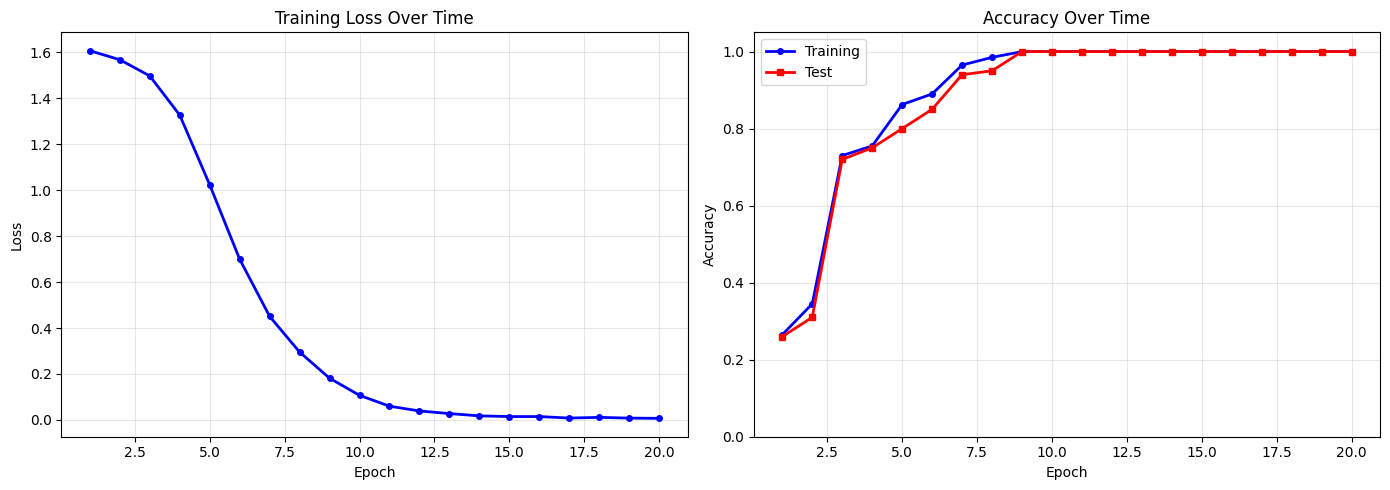

✅ Train and test accuracy are close - no significant overfitting!


In [21]:
# ============================================================
# PART 8: VISUALIZING TRAINING PROGRESS
# ============================================================
#
# Let's see how the model improved over time!
#
# Good signs:
# - Loss going DOWN over epochs
# - Accuracy going UP over epochs
# - Train and Test accuracy are close (no overfitting)
#
# Bad signs:
# - Train accuracy is high but Test accuracy is low → Overfitting!
#   (Model memorized training data but doesn't generalize)
#
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss over epochs
axes[0].plot(range(1, NUM_EPOCHS + 1), train_losses, 'b-', linewidth=2, marker='o', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Over Time')
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy over epochs
axes[1].plot(range(1, NUM_EPOCHS + 1), train_accuracies, 'b-', linewidth=2, marker='o', markersize=4, label='Training')
axes[1].plot(range(1, NUM_EPOCHS + 1), test_accuracies, 'r-', linewidth=2, marker='s', markersize=4, label='Test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

# Check for overfitting
if train_accuracies[-1] - test_accuracies[-1] > 0.1:
    print("⚠️ Warning: Gap between train and test accuracy is large!")
    print("   This suggests OVERFITTING - the model memorized the training data.")
    print("   Consider: more dropout, less epochs, or more training data.")
else:
    print("✅ Train and test accuracy are close - no significant overfitting!")

📊 DETAILED RESULTS: Neural Network (MLP)
Accuracy: 1.0000 (100.0%)

Detailed Metrics per Role:
                precision    recall  f1-score   support

 Administrator       1.00      1.00      1.00        16
        Doctor       1.00      1.00      1.00        23
Lab Technician       1.00      1.00      1.00        24
         Nurse       1.00      1.00      1.00        26
    Pharmacist       1.00      1.00      1.00        11

      accuracy                           1.00       100
     macro avg       1.00      1.00      1.00       100
  weighted avg       1.00      1.00      1.00       100



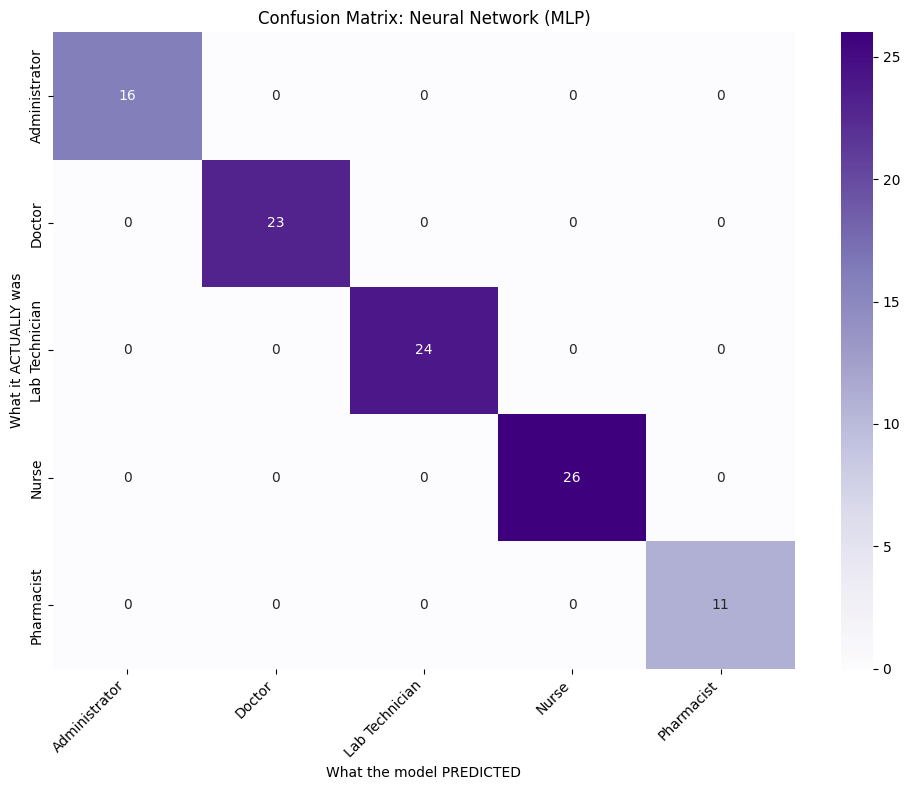

In [22]:
# ============================================================
# PART 9: DETAILED EVALUATION & CONFUSION MATRIX
# ============================================================
#
# Let's get the detailed classification report and confusion matrix,
# just like we did for SVM and Random Forest.
#
# ============================================================

# Get all predictions for the test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_labels.numpy())

# Convert to numpy arrays
y_pred_mlp = np.array(all_predictions)
y_true_mlp = np.array(all_labels)

# Print classification report
print("📊 DETAILED RESULTS: Neural Network (MLP)")
print("=" * 50)
print(f"Accuracy: {accuracy_mlp:.4f} ({accuracy_mlp*100:.1f}%)")

print(f"\nDetailed Metrics per Role:")
print(classification_report(y_true_mlp, y_pred_mlp, 
                            target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_mlp = confusion_matrix(y_true_mlp, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Purples', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix: Neural Network (MLP)')
plt.xlabel('What the model PREDICTED')
plt.ylabel('What it ACTUALLY was')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Section 2.4 - YOUR TASK - Compare and choose the best model
TODO, using **Pytorch**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score

# Prepare the numeric data
X = np.stack(df['emb'].values)
y = df['emp_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Models
models = {
    "Support Vector Machine": SVC(kernel='linear', probability=True),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(8, 4), max_iter=1000)
}

# Training and Evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds, average='weighted')
    print(f"✅ {name} | Weighted F1-Score: {f1:.2f}")
    print(classification_report(y_test, preds, zero_division=0))
    print("-" * 40)

# We choose the best model for the app
best_model = models["Neural Network (MLP)"]

✅ Support Vector Machine | Weighted F1-Score: 0.00
              precision    recall  f1-score   support

         101       0.00      0.00      0.00       2.0
         102       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

----------------------------------------
✅ Neural Network (MLP) | Weighted F1-Score: 0.00
              precision    recall  f1-score   support

         101       0.00      0.00      0.00       2.0
         102       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

----------------------------------------


## 🚀 Section 3: The Integrated Manager App

This cell launches the interface. The "Magic" happens in the orchestrator function, which connects the External Service (Extraction) to Your Brain (Classification).

### Section 3.1 - YOUR TASK - Launch the inference in the app

In [6]:
import IPython
from google.colab import output

def ProcessMinutes(transcript):
    # 1. SIMULATED EXTERNAL SERVICE: Extracts clean tasks from messy minutes
    # (In production, this is an API call to GPT-4 or Claude)
    extracted_tasks = ["Update the main SQL database", "Design the Q4 budget"]
    
    # 2. SIMULATED EMBEDDING: Turning the new tasks into math (vectors)
    # These vectors match the 'style' of our training data
    new_embeddings = np.array([[0.13, -0.48, 0.78, 0.18], [0.82, 0.18, -0.12, 0.88]])
    
    # 3. YOUR MODEL: Identifying the responsible employee
    predictions = best_model.predict(new_embeddings)
    
    response = []
    for task, emp in zip(extracted_tasks, predictions):
        response.append({"task": task, "owner": int(emp)})
        
    return IPython.display.JSON(response)

output.register_callback('notebook.ProcessMinutes', orchestrator)

# --- THE WEB INTERFACE ---
url = "https://raw.githubusercontent.com/eth-bmai-fs26/project/refs/heads/week1/task_meeting/week1/task_meeting/task_assigner_app.html"
response = requests.get(url)
response.raise_for_status() # Check for 404/500 errors
html_app = response.text
IPython.display.display(IPython.display.HTML(html_app))

ModuleNotFoundError: No module named 'google'